# What is the impact of agricultural corn field expansion rate on deforestation rate in countries?


By Platypus

## Table of Contents
1. [Building our table](#Getting-the-Data)
    - [ISO3](#ISO3)
    - [Variable X: Cornfield data](#Cornfield-Data)
    - [Land size](#Land-Size)
    - [Variable Y: Forest area](#Forest-Area)
    - [Heterogeneity Variable: Land available for corn expansion other than forests](#Heterogeneity-variable)
    - [Confounders](#Confounders)
        - [Corn Price Data](#Corn-Price-Data)
        - [Delta °T](#Delta-T)  
        - [Average Temperature](#Average-Temperature)
        - [GDP](#GDP)
        - [Rainfall](#Rainfall)
        - [Corruption: The Bayesian Corruption Indicator (bci_bci)](#Corruption)
    

In [1]:
# CSV files
filepath = 'https://raw.githubusercontent.com/ZeliaDec/DataScience/main/Data/'
csv_forest = filepath + "Deforest.xlsx"
csv_cornland = filepath + 'FAOSTAT_data_en_10-2-2024.csv'
csv_landcover = filepath + "FAOSTAT_data_en_11-18-2024.csv"

## Getting the Data

### Installing packages

In [2]:
pip install wbdata

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pycountry

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Import libraries

In [4]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import wbdata
import numpy as np
import pycountry
import plotly.express as px

/Users/zeliadecaillet/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### ISO3

In [5]:
# Function to get ISO-3 country code from country name
def get_iso3(country_name):
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except LookupError:
        return None

In [6]:
# Lookup the country by ISO3 code
country = pycountry.countries.get(alpha_3='VAT')

# Display the country name
country.name

'Holy See (Vatican City State)'

In [7]:
country_mapping = {
    'United Republic of Tanzania': 'Tanzania',
    'United States of America': 'United States',
    'Venezuela, RB': 'Venezuela',
    'Bahamas, The': 'Bahamas',
    'Congo, Dem. Rep.':'Congo, The Democratic Republic of the',
    'Congo, Rep.': 'Congo',
    'Turkiye': 'Türkiye',
    "Cote d'Ivoire":"Côte d'Ivoire",
    'St. Lucia':'Saint Lucia',
    "Korea, Dem. People's Rep." : "Korea, Democratic People's Republic of",
    'Korea, Rep.': 'Korea, Republic of',
    'Lao PDR':"Lao People's Democratic Republic",
    'Gambia, The': 'Gambia',
    'Egypt, Arab Rep.': 'Egypt',
    'Iran, Islamic Rep.': 'Iran, Islamic Republic of',
    'St. Kitts and Nevis': 'Saint Kitts and Nevis',
    'St. Vincent and the Grenadines':'Saint Vincent and the Grenadines',
    'Micronesia, Fed. Sts.': 'Micronesia, Federated States of',
    'Virgin Islands (U.S.)':'Virgin Islands, U.S.',
    'Yemen, Rep.':'Yemen',
    'Macao SAR, China': 'Macao',
    'St. Martin (French part)':'Saint Martin (French part)',
    'Curacao':'Curaçao',
    'Hong Kong SAR, China': 'Hong Kong'
    # You can add more mappings if necessary
}

In [8]:
country_not_country = [
    'Africa Eastern and Southern',
    'Africa Western and Central',
    'Central Europe and the Baltics',
    'Upper middle income',
    'East Asia & Pacific (IDA & IBRD countries)',
    'East Asia & Pacific',
    'East Asia & Pacific (excluding high income)',
    'Euro area',
    'Europe & Central Asia',
    'Europe & Central Asia (IDA & IBRD countries)',
    'Europe & Central Asia (excluding high income)',
    'European Union',
    'Fragile and conflict affected situations',
    'Heavily indebted poor countries (HIPC)',
    'Early-demographic dividend',
    'High income',
    'IBRD only',
    'IDA & IBRD total',
    'IDA blend',
    'IDA only',
    'IDA total',
    'Late-demographic dividend',
    'Latin America & Caribbean',
    'Latin America & Caribbean (excluding high income)',
    'Least developed countries: UN classification',
    'Low & middle income',
    'Lower middle income',
    'Middle East & North Africa',
    'Middle East & North Africa (IDA & IBRD countries)',
    'Middle income',
    'Low income',
    'North America',
    'OECD members',
    'Other small states',
    'Pacific island small states',
    'Post-demographic dividend',
    'Small states',
    'South Asia',
    'Sub-Saharan Africa (IDA & IBRD countries)',
    'Sub-Saharan Africa (excluding high income)',
    'Pre-demographic dividend',
    'South Asia (IDA & IBRD)',
    'Sub-Saharan Africa',
    'West Bank and Gaza',
    'Caribbean small states',
    'Channel Islands',
    'Arab World',
    'Middle East & North Africa (excluding high income)',
    'Latin America & the Caribbean (IDA & IBRD countries)',
    'Eastern and Southern Africa',
    'Western and Central Africa',
    'Not classified',
    'World'
]


### Cornfield Data

In [9]:
corn_df = pd.read_csv(csv_cornland)
corn_df.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,112,Maize (corn),1961,1961,ha,500000,A,Official figure,NaN
1,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,112,Maize (corn),1962,1962,ha,500000,A,Official figure,NaN
2,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,112,Maize (corn),1963,1963,ha,500000,A,Official figure,NaN
3,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,112,Maize (corn),1964,1964,ha,505000,A,Official figure,NaN
4,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,112,Maize (corn),1965,1965,ha,500000,A,Official figure,NaN


In [10]:
# Filter the data for the year 1992
data_1992 = corn_df[corn_df["Year"] == 1992]

# Find countries with missing values in the "Value" column
countries_no_value_1992 = data_1992[data_1992["Value"].isnull()]["Area"].unique()

# Convert to list
countries_no_value_1992_list = countries_no_value_1992.tolist()

print(countries_no_value_1992_list)

[]


In [11]:
data_1992 = data_1992[["Area", "Value"]]
data_1992.rename(columns={"Area": "country", "Value": "corn1992"}, inplace=True)
data_1992["corn1992"] = data_1992["corn1992"]*0.01
data_1992 = data_1992.dropna()
data_1992.head()

,country,corn1992
31,Afghanistan,2000.00
93,Albania,627.36
155,Algeria,2.90
217,Angola,8470.00
274,Antigua and Barbuda,0.30


In [12]:
#Filtering the data between 2000 and 2021
corn_field_data = corn_df
corn_field_data = corn_field_data[(corn_field_data['Year'] >= 2000) & (corn_field_data['Year'] <= 2021)]
corn_field_data.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
39,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,112,Maize (corn),2000,2000,ha,96000,A,Official figure,NaN
40,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,112,Maize (corn),2001,2001,ha,80000,A,Official figure,NaN
41,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,112,Maize (corn),2002,2002,ha,100000,A,Official figure,NaN
42,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,112,Maize (corn),2003,2003,ha,250000,A,Official figure,NaN
43,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,112,Maize (corn),2004,2004,ha,250000,A,Official figure,NaN


In [13]:
corn_field_data["Note"].unique()

array([nan, 'Unofficial figure'], dtype=object)

In [14]:
corn_field_data["Flag Description"].unique()

array(['Official figure', 'Estimated value', 'Imputed value',
       'Figure from international organizations',
       'Missing value (data cannot exist, not applicable)'], dtype=object)

In [15]:
corn_field_data = corn_field_data[(corn_field_data["Flag Description"] == "Official figure") & (corn_field_data["Note"] != "Unofficial figure")]

In [16]:
#Unique country amount: Does the number of countires in this data match with deforestation data?
print("Number of countries in the corn field dataset: ",len(corn_field_data["Area"].unique()))

Number of countries in the corn field dataset:  162


In [17]:
corn_field_data.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
39,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,112,Maize (corn),2000,2000,ha,96000,A,Official figure,NaN
40,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,112,Maize (corn),2001,2001,ha,80000,A,Official figure,NaN
41,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,112,Maize (corn),2002,2002,ha,100000,A,Official figure,NaN
42,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,112,Maize (corn),2003,2003,ha,250000,A,Official figure,NaN
43,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,112,Maize (corn),2004,2004,ha,250000,A,Official figure,NaN


In [18]:
#filter only the relevant columns
df_corn = corn_field_data
df_corn = df_corn[["Area","Value","Year"]]
df_corn

,Area,Value,Year
39,Afghanistan,96000,2000
40,Afghanistan,80000,2001
41,Afghanistan,100000,2002
42,Afghanistan,250000,2003
43,Afghanistan,250000,2004
...,...,...,...
9543,Zimbabwe,1099945,2017
9544,Zimbabwe,1155075,2018
9545,Zimbabwe,991354,2019
9546,Zimbabwe,1018884,2020


In [19]:
areas_to_exclude = df_corn[df_corn["Value"] == 0]["Area"].unique() #These countries include 0 values
#Exclude these countries completely
df_corn = df_corn[~df_corn['Area'].isin(areas_to_exclude)]
df_corn

,Area,Value,Year
39,Afghanistan,96000,2000
40,Afghanistan,80000,2001
41,Afghanistan,100000,2002
42,Afghanistan,250000,2003
43,Afghanistan,250000,2004
...,...,...,...
9543,Zimbabwe,1099945,2017
9544,Zimbabwe,1155075,2018
9545,Zimbabwe,991354,2019
9546,Zimbabwe,1018884,2020


In [20]:
#Missing values
df_corn.isna().sum()

Area     0
Value    0
Year     0
dtype: int64

In [21]:
value_counts_per_area = df_corn.groupby("Area")["Value"].count()

# Filter to get only the areas where the count is not equal to 22
areas_not_equal_to_22 = value_counts_per_area[value_counts_per_area != 22].index
areas_not_equal_to_22

Index(['Antigua and Barbuda', 'Bahamas', 'Barbados', 'Bhutan',
       'Bosnia and Herzegovina', 'Botswana', 'Burundi', 'Cabo Verde',
       'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Congo',
       'Côte d'Ivoire', 'Democratic People's Republic of Korea',
       'Democratic Republic of the Congo', 'Denmark', 'Eritrea', 'Eswatini',
       'Fiji', 'French Guiana', 'Gambia', 'Ghana', 'Guatemala',
       'Guinea-Bissau', 'Haiti', 'Honduras', 'Indonesia',
       'Iran (Islamic Republic of)', 'Iraq', 'Israel', 'Japan', 'Kuwait',
       'Lebanon', 'Lesotho', 'Libya', 'Lithuania', 'Madagascar', 'Malaysia',
       'Maldives', 'Mauritania', 'Montenegro', 'Mozambique', 'Namibia',
       'New Caledonia', 'Nigeria', 'Oman', 'Papua New Guinea', 'Puerto Rico',
       'Rwanda', 'Saint Vincent and the Grenadines', 'Saudi Arabia', 'Serbia',
       'Serbia and Montenegro', 'Sierra Leone', 'South Sudan', 'Sri Lanka',
       'Sudan', 'Sudan (former)', 'Sweden', 'Tajikistan', 'Thailand',
 

In [22]:
df_corn = df_corn[~df_corn["Area"].isin(areas_not_equal_to_22)]
df_corn

,Area,Value,Year
39,Afghanistan,96000,2000
40,Afghanistan,80000,2001
41,Afghanistan,100000,2002
42,Afghanistan,250000,2003
43,Afghanistan,250000,2004
...,...,...,...
9481,Zambia,1433944,2017
9482,Zambia,1086006,2018
9483,Zambia,841693,2019
9484,Zambia,1333519,2020


In [23]:
df_corn['iso3'] = df_corn['Area'].apply(get_iso3)
df_corn[df_corn['iso3'].isnull()]

/var/folders/z1/yry6nb4j25bg_5n5f28yn9zw0000gn/T/ipykernel_935/3983791102.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corn['iso3'] = df_corn['Area'].apply(get_iso3)


,Area,Value,Year,iso3
1057,Bolivia (Plurinational State of),307292,2000,None
1058,Bolivia (Plurinational State of),306118,2001,None
1059,Bolivia (Plurinational State of),310465,2002,None
1060,Bolivia (Plurinational State of),295509,2003,None
1061,Bolivia (Plurinational State of),313849,2004,None
...,...,...,...,...
7175,Republic of Korea,15074,2017,None
7176,Republic of Korea,15472,2018,None
7177,Republic of Korea,14840,2019,None
7178,Republic of Korea,15633,2020,None


In [24]:
# Reverting to previous data before dropping and then manually resolving country mismatches
country_mapping_corn = {
    'Bolivia (Plurinational State of)':'Bolivia, Plurinational State of',
    'China, Taiwan Province of':'Taiwan, Province of China',
    'China': 'China_',
    'China, mainland':'China',
    'Democratic Republic of the Congo':'Congo, The Democratic Republic of the',
    'Iran (Islamic Republic of)':'Iran, Islamic Republic of',
    'Micronesia (Federated States of)': 'Micronesia, Federated States of',
    'Netherlands (Kingdom of the)':'Netherlands',
    'Republic of Korea': 'Korea, Republic of',
    'Venezuela (Bolivarian Republic of)':'Venezuela, Bolivarian Republic of',
    # You can add more mappings if necessary
}

df_corn['Area'] = df_corn['Area'].replace(country_mapping_corn)

/var/folders/z1/yry6nb4j25bg_5n5f28yn9zw0000gn/T/ipykernel_935/1586715189.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corn['Area'] = df_corn['Area'].replace(country_mapping_corn)


In [25]:
df_corn['iso3'] = df_corn['Area'].apply(get_iso3)
df_corn[df_corn['iso3'].isnull()]

/var/folders/z1/yry6nb4j25bg_5n5f28yn9zw0000gn/T/ipykernel_935/3983791102.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corn['iso3'] = df_corn['Area'].apply(get_iso3)


,Area,Value,Year,iso3
1894,China_,23086228,2000,None
1895,China_,24310506,2001,None
1896,China_,24660837,2002,None
1897,China_,24092820,2003,None
1898,China_,25467145,2004,None
1899,China_,26379450,2005,None
1900,China_,28482649,2006,None
1901,China_,29496901,2007,None
1902,China_,29882708,2008,None
1903,China_,31203367,2009,None


In [26]:
df_corn = df_corn.dropna()
df_corn = df_corn.reset_index()
df_corn.drop('index', axis=1, inplace=True)
df_corn.rename(columns={'Area':'country', 'Value':'Total Size Cornfield in ha'}, inplace=True)
df_corn['Total Size Cornfield in sq km'] = df_corn['Total Size Cornfield in ha']*0.01
df_corn.head()

,country,Total Size Cornfield in ha,Year,iso3,Total Size Cornfield in sq km
0,Afghanistan,96000,2000,AFG,960.0
1,Afghanistan,80000,2001,AFG,800.0
2,Afghanistan,100000,2002,AFG,1000.0
3,Afghanistan,250000,2003,AFG,2500.0
4,Afghanistan,250000,2004,AFG,2500.0


In [27]:
data_1992

,country,corn1992
31,Afghanistan,2000.00
93,Albania,627.36
155,Algeria,2.90
217,Angola,8470.00
274,Antigua and Barbuda,0.30
...,...,...
9239,Venezuela (Bolivarian Republic of),3742.47
9301,Viet Nam,4780.00
9363,Yemen,469.44
9456,Zambia,6613.05


In [28]:
df_corn = pd.merge(df_corn, data_1992, on='country', how='left')
df_corn = df_corn.dropna()
df_corn

,country,Total Size Cornfield in ha,Year,iso3,Total Size Cornfield in sq km,corn1992
0,Afghanistan,96000,2000,AFG,960.00,2000.00
1,Afghanistan,80000,2001,AFG,800.00,2000.00
2,Afghanistan,100000,2002,AFG,1000.00,2000.00
3,Afghanistan,250000,2003,AFG,2500.00,2000.00
4,Afghanistan,250000,2004,AFG,2500.00,2000.00
...,...,...,...,...,...,...
1909,Zambia,1433944,2017,ZMB,14339.44,6613.05
1910,Zambia,1086006,2018,ZMB,10860.06,6613.05
1911,Zambia,841693,2019,ZMB,8416.93,6613.05
1912,Zambia,1333519,2020,ZMB,13335.19,6613.05


### Land size

In [29]:
# Get data for 'Land area (sq. km)' for all countries
indicators = {'AG.LND.TOTL.K2': 'Land area (sq. km)'}
data = wbdata.get_dataframe(indicators)

# Display the land area for all countries
org_data = data.reset_index()

#Converting the year column to integer
org_data['date'] = org_data['date'].astype(int)

org_data.head()

,country,date,Land area (sq. km)
0,Africa Eastern and Southern,2023,NaN
1,Africa Eastern and Southern,2022,NaN
2,Africa Eastern and Southern,2021,1.484509e+07
3,Africa Eastern and Southern,2020,1.484509e+07
4,Africa Eastern and Southern,2019,1.484513e+07


In [30]:
filtered_data = org_data[(org_data['date'] >= 2000) & (org_data['date'] <= 2021)]

avg_land_size_df = filtered_data
avg_land_size_df

,country,date,Land area (sq. km)
2,Africa Eastern and Southern,2021,1.484509e+07
3,Africa Eastern and Southern,2020,1.484509e+07
4,Africa Eastern and Southern,2019,1.484513e+07
5,Africa Eastern and Southern,2018,1.484512e+07
6,Africa Eastern and Southern,2017,1.484510e+07
...,...,...,...
16979,Zimbabwe,2004,3.868500e+05
16980,Zimbabwe,2003,3.868500e+05
16981,Zimbabwe,2002,3.868500e+05
16982,Zimbabwe,2001,3.868500e+05


In [31]:
avg_land_size_df['iso3'] = avg_land_size_df['country'].apply(get_iso3)

/var/folders/z1/yry6nb4j25bg_5n5f28yn9zw0000gn/T/ipykernel_935/1108197642.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_land_size_df['iso3'] = avg_land_size_df['country'].apply(get_iso3)


In [32]:
avg_land_size_df[avg_land_size_df['iso3'].isnull()]

,country,date,Land area (sq. km),iso3
2,Africa Eastern and Southern,2021,1.484509e+07,None
3,Africa Eastern and Southern,2020,1.484509e+07,None
4,Africa Eastern and Southern,2019,1.484513e+07,None
5,Africa Eastern and Southern,2018,1.484512e+07,None
6,Africa Eastern and Southern,2017,1.484510e+07,None
...,...,...,...,...
16851,"Yemen, Rep.",2004,5.279700e+05,None
16852,"Yemen, Rep.",2003,5.279700e+05,None
16853,"Yemen, Rep.",2002,5.279700e+05,None
16854,"Yemen, Rep.",2001,5.279700e+05,None


In [33]:
avg_land_size_df['country'] = avg_land_size_df['country'].replace(country_mapping)

/var/folders/z1/yry6nb4j25bg_5n5f28yn9zw0000gn/T/ipykernel_935/344355826.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_land_size_df['country'] = avg_land_size_df['country'].replace(country_mapping)


In [34]:
avg_land_size_df = avg_land_size_df[~avg_land_size_df['country'].isin(country_not_country)]

In [35]:
avg_land_size_df['iso3'] = avg_land_size_df['country'].apply(get_iso3)
avg_land_size_df[avg_land_size_df['iso3'].isnull()]

/var/folders/z1/yry6nb4j25bg_5n5f28yn9zw0000gn/T/ipykernel_935/724237593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_land_size_df['iso3'] = avg_land_size_df['country'].apply(get_iso3)


,country,date,Land area (sq. km),iso3
9858,Kosovo,2021,NaN,None
9859,Kosovo,2020,NaN,None
9860,Kosovo,2019,NaN,None
9861,Kosovo,2018,NaN,None
9862,Kosovo,2017,NaN,None
9863,Kosovo,2016,NaN,None
9864,Kosovo,2015,NaN,None
9865,Kosovo,2014,NaN,None
9866,Kosovo,2013,NaN,None
9867,Kosovo,2012,NaN,None


In [36]:
avg_land_size_df = avg_land_size_df.dropna(subset=['iso3'])
avg_land_size_df.head()

,country,date,Land area (sq. km),iso3
3138,Afghanistan,2021,652230.0,AFG
3139,Afghanistan,2020,652230.0,AFG
3140,Afghanistan,2019,652230.0,AFG
3141,Afghanistan,2018,652230.0,AFG
3142,Afghanistan,2017,652230.0,AFG


In [37]:
avg_land_size_df = avg_land_size_df.reset_index()
avg_land_size_df.drop('index', axis=1, inplace=True)
avg_land_size_df.rename(columns={'Land area (sq. km)':'landArea','date':'Year'}, inplace=True)
avg_land_size_df.head()

,country,Year,landArea,iso3
0,Afghanistan,2021,652230.0,AFG
1,Afghanistan,2020,652230.0,AFG
2,Afghanistan,2019,652230.0,AFG
3,Afghanistan,2018,652230.0,AFG
4,Afghanistan,2017,652230.0,AFG


### Create a table containing the x,y and heterogeneity variable

In [38]:
avg_land_size_df.head()

,country,Year,landArea,iso3
0,Afghanistan,2021,652230.0,AFG
1,Afghanistan,2020,652230.0,AFG
2,Afghanistan,2019,652230.0,AFG
3,Afghanistan,2018,652230.0,AFG
4,Afghanistan,2017,652230.0,AFG


In [39]:
df_corn.head()

,country,Total Size Cornfield in ha,Year,iso3,Total Size Cornfield in sq km,corn1992
0,Afghanistan,96000,2000,AFG,960.0,2000.0
1,Afghanistan,80000,2001,AFG,800.0,2000.0
2,Afghanistan,100000,2002,AFG,1000.0,2000.0
3,Afghanistan,250000,2003,AFG,2500.0,2000.0
4,Afghanistan,250000,2004,AFG,2500.0,2000.0


In [40]:
final_merged_df = pd.merge(avg_land_size_df, df_corn, on=['iso3', 'Year'], how='outer')

final_merged_df.head()

,country_x,Year,landArea,iso3,country_y,Total Size Cornfield in ha,Total Size Cornfield in sq km,corn1992
0,Aruba,2000,180.0,ABW,NaN,NaN,NaN,NaN
1,Aruba,2001,180.0,ABW,NaN,NaN,NaN,NaN
2,Aruba,2002,180.0,ABW,NaN,NaN,NaN,NaN
3,Aruba,2003,180.0,ABW,NaN,NaN,NaN,NaN
4,Aruba,2004,180.0,ABW,NaN,NaN,NaN,NaN


In [41]:
final_merged_df.isnull().sum()

country_x                           0
Year                                0
landArea                           57
iso3                                0
country_y                        2992
Total Size Cornfield in ha       2992
Total Size Cornfield in sq km    2992
corn1992                         2992
dtype: int64

In [42]:
# Check for missing values across each column and group by 'country'
missing_values_per_country = final_merged_df.groupby('country_x').apply(lambda x: x.isna().sum())

# Filter to show only countries with at least one missing value
countries_with_missing_values = missing_values_per_country[missing_values_per_country.sum(axis=1) > 0]

# Display the result
print(countries_with_missing_values)

                      country_x  Year  landArea  iso3  country_y  \
country_x                                                          
American Samoa                0     0         0     0         22   
Andorra                       0     0         0     0         22   
Antigua and Barbuda           0     0         0     0         22   
Aruba                         0     0         0     0         22   
Bahamas                       0     0         0     0         22   
...                         ...   ...       ...   ...        ...   
United Kingdom                0     0         0     0         22   
Vanuatu                       0     0         0     0         22   
Venezuela                     0     0         0     0         22   
Virgin Islands, U.S.          0     0         0     0         22   
Zimbabwe                      0     0         0     0         22   

                      Total Size Cornfield in ha  \
country_x                                          
American Sa

/var/folders/z1/yry6nb4j25bg_5n5f28yn9zw0000gn/T/ipykernel_935/3302613329.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_values_per_country = final_merged_df.groupby('country_x').apply(lambda x: x.isna().sum())


In [43]:
final_merged_df.drop(['country_y'], axis=1, inplace=True)
final_merged_df.rename(columns={'country_x': 'Country'}, inplace=True)
final_merged_df = final_merged_df.dropna()
final_merged_df

,Country,Year,landArea,iso3,Total Size Cornfield in ha,Total Size Cornfield in sq km,corn1992
22,Afghanistan,2000,652230.0,AFG,96000.0,960.00,2000.00
23,Afghanistan,2001,652230.0,AFG,80000.0,800.00,2000.00
24,Afghanistan,2002,652230.0,AFG,100000.0,1000.00,2000.00
25,Afghanistan,2003,652230.0,AFG,250000.0,2500.00,2000.00
26,Afghanistan,2004,652230.0,AFG,250000.0,2500.00,2000.00
...,...,...,...,...,...,...,...
4681,Zambia,2017,743390.0,ZMB,1433944.0,14339.44,6613.05
4682,Zambia,2018,743390.0,ZMB,1086006.0,10860.06,6613.05
4683,Zambia,2019,743390.0,ZMB,841693.0,8416.93,6613.05
4684,Zambia,2020,743390.0,ZMB,1333519.0,13335.19,6613.05


In [44]:
final_merged_df = final_merged_df.reset_index(drop=True)
final_merged_df

,Country,Year,landArea,iso3,Total Size Cornfield in ha,Total Size Cornfield in sq km,corn1992
0,Afghanistan,2000,652230.0,AFG,96000.0,960.00,2000.00
1,Afghanistan,2001,652230.0,AFG,80000.0,800.00,2000.00
2,Afghanistan,2002,652230.0,AFG,100000.0,1000.00,2000.00
3,Afghanistan,2003,652230.0,AFG,250000.0,2500.00,2000.00
4,Afghanistan,2004,652230.0,AFG,250000.0,2500.00,2000.00
...,...,...,...,...,...,...,...
1711,Zambia,2017,743390.0,ZMB,1433944.0,14339.44,6613.05
1712,Zambia,2018,743390.0,ZMB,1086006.0,10860.06,6613.05
1713,Zambia,2019,743390.0,ZMB,841693.0,8416.93,6613.05
1714,Zambia,2020,743390.0,ZMB,1333519.0,13335.19,6613.05


In [45]:
last_df = final_merged_df

In [46]:
len(last_df['Country'].unique())

78

# Forest area 
 
For both the variable Y and the heterogeneity variable, We will use a [database about Global Land Cover](https://www.fao.org/faostat/en/#data/LC) provided by FAO, where we have data for 247 countries, and for 14 classes of land cover :
1. Artificial surfaces (including urban and associated areas)
2. Herbaceous crops
3. Woody crops
4. Multiple or layered crops (Not mapped)
5. Grassland
6. Tree-covered areas
7. Mangroves
8. Shrub-covered areas
9. Shrubs and/or herbaceous vegetation, aquatic or regularly flooded
10. Sparsely natural vegetated areas (Not mapped)
11. Terrestrial barren land
12. Permanent snow and glaciers
13. Inland water bodies
14. Coastal water bodies and intertidal areas

To compute the land available for corn expansion, we will compute the sum of land categories that seem suitable for corn expansion, so potentially convertible lands other than forests :  
- __Herbaceous crops__ : represents existing cropland already used for agricultural purposes. These lands are highly suitable for corn expansion and may involve crop rotation or intensification strategies
- __Grassland__ : Grasslands are often used as pastures but can be converted into cropland. These areas are considered moderately suitable for corn expansion, especially in regions with high land-use pressure
- __Shrub-covered areas__ : Shrublands, while less fertile than grasslands, can still be converted for agricultural use with proper inputs and management. These areas are often targeted in marginal expansions for crops like corn

The reasoning behing is that we might see a stronger relationship between corn expansion and deforestation in countries where there is little land available for corn expansion other than forests, specifically in countries where there is low regulation and high forest covers, because in these regions clearing forests can be economically cheaper, the sale of timber from deforestation provides an additional revenue stream, offsetting the costs of converting forests to farmland. In highly regulated or land-constrained regions, converting existing croplands rather than forests is more likely because there are strong regulations protect forests, infrastructure for existing croplands is already in place, and incentives encourage intensification (e.g., improving yields) over land expansion. We will create a dummy that splits our dataset into two groups:
- Group 0 :  Countries with land suitable and available for corn expansion lower than its median
- Group 1 : Countries with land suitable and available for corn expansion higher than its median

In [47]:
landcover_data = pd.read_csv(csv_landcover)
landcover_data.columns

Index(['Domain Code', 'Domain', 'Area Code (M49)', 'Area', 'Element Code',
       'Element', 'Item Code', 'Item', 'Year Code', 'Year', 'Unit', 'Value',
       'Flag', 'Flag Description'],
      dtype='object')

In [48]:
len(landcover_data['Area'].unique())

247

In [49]:
def m49_to_iso3(m49_code):
    for country in pycountry.countries:
        if hasattr(country, 'numeric') and int(country.numeric) == m49_code:
            return country.alpha_3
    return None
landcover_data['iso3']=landcover_data['Area Code (M49)'].apply(m49_to_iso3)

In [50]:
len(landcover_data['iso3'].unique())

237

In [51]:
landcover_data[landcover_data['iso3'].isnull()]["Area"].unique()

array(['Belgium-Luxembourg', 'Channel Islands', 'China', 'Czechoslovakia',
       'Ethiopia PDR', 'Johnston Island', 'Midway Island',
       'Netherlands Antilles (former)', 'Serbia and Montenegro',
       'Sudan (former)', 'Wake Island'], dtype=object)

In [52]:
# Convert 'Value' from 1000 hectares to square km
#landcover_data['Value_sq_km'] = landcover_data['Value'] * 10# 1 hectare = 10,000 square meters
landcover_data['Value_sq_km'] = landcover_data['Value'] * 10

In [53]:
forests = landcover_data[landcover_data['Item']=='Tree-covered areas']
forests.rename(columns={'Area': 'Country'}, inplace=True)
forests.rename(columns={'Value_sq_km': 'Tree-covered areas in sq km'}, inplace=True)
forests = forests[['Country','iso3', 'Year', 'Element','Tree-covered areas in sq km']]
forests = forests.dropna()
len(forests['Country'].unique())

/var/folders/z1/yry6nb4j25bg_5n5f28yn9zw0000gn/T/ipykernel_935/4269415020.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forests.rename(columns={'Area': 'Country'}, inplace=True)
/var/folders/z1/yry6nb4j25bg_5n5f28yn9zw0000gn/T/ipykernel_935/4269415020.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forests.rename(columns={'Value_sq_km': 'Tree-covered areas in sq km'}, inplace=True)


236

In [54]:
forests=forests[forests['Element']=='Area from CCI_LC']
forests=forests[['Country','iso3','Year','Tree-covered areas in sq km']]

# **Heterogeneity variable**
## Land available for corn expansion other than forests

### Why ?
- __Direct Relevance to Corn Expansion__:
    This variable captures the potential for agricultural growth, specifically for corn, by estimating land areas that could feasibly be converted to cornfields.
    Unlike general measures of land availability, it focuses on lands that are ecologically and practically suitable for corn cultivation.

- __Variation Across Countries__:
    The variable inherently reflects differences between countries, such as urbanization levels, existing cropland distribution, and natural geographic constraints, making it an ideal heterogeneity factor.
    Countries with more available land for corn expansion may exhibit stronger links between corn expansion and deforestation, while those with limited availability may rely on intensification rather than land clearing.

- __Focus on Agricultural Pressure__:
    This variable aligns directly with the agricultural pressures driving deforestation, providing a more targeted perspective than broader variables like general cropland area.
### How is it constructed ?
To compute the land available for corn expansion, we will compute the sum of land categories that seem suitable for corn expansion, so potentially convertible lands other than forests :  
- __Herbaceous crops__ : represents existing cropland already used for agricultural purposes. These lands are highly suitable for corn expansion and may involve crop rotation or intensification strategies
- __Grassland__ : Grasslands are often used as pastures but can be converted into cropland. These areas are considered moderately suitable for corn expansion, especially in regions with high land-use pressure
- __Shrub-covered areas__ : Shrublands, while less fertile than grasslands, can still be converted for agricultural use with proper inputs and management. These areas are often targeted in marginal expansions for crops like corn

The reasoning behing is that we might see a stronger relationship between corn expansion and deforestation in countries where there is little land available for corn expansion other than forests, specifically in countries where there is low regulation and high forest covers, because in these regions clearing forests can be economically cheaper, the sale of timber from deforestation provides an additional revenue stream, offsetting the costs of converting forests to farmland. In highly regulated or land-constrained regions, converting existing croplands rather than forests is more likely because there are strong regulations protect forests, infrastructure for existing croplands is already in place, and incentives encourage intensification (e.g., improving yields) over land expansion. We will create a dummy that splits our dataset into two groups:
- Group 0 :  Countries with land suitable and available for corn expansion lower than its median
- Group 1 : Countries with land suitable and available for corn expansion higher than its median

In [55]:
landcover_data['Item'].unique()

array(['Artificial surfaces (including urban and associated areas)',
       'Herbaceous crops', 'Woody crops', 'Multiple or layered crops',
       'Grassland', 'Tree-covered areas', 'Mangroves',
       'Shrub-covered areas',
       'Shrubs and/or herbaceous vegetation, aquatic or regularly flooded',
       'Sparsely natural vegetated areas', 'Terrestrial barren land',
       'Permanent snow and glaciers', 'Inland water bodies',
       'Coastal water bodies and intertidal areas'], dtype=object)

In [56]:
suitable_categories = ['Herbaceous crops', 'Grassland', 'Shrub-covered areas']
suitable_land = landcover_data[landcover_data['Item'].isin(suitable_categories)]

In [57]:
# Pivot the data to have categories as columns
pivoted_suitable_land = suitable_land.pivot_table(index=['Area', 'Year', 'iso3'], columns='Item', values='Value', aggfunc='sum').reset_index()

# Fill NaN values with 0
pivoted_suitable_land = pivoted_suitable_land.fillna(0)

# Sum the suitable categories for each country and year
pivoted_suitable_land['Total Suitable Land'] = pivoted_suitable_land['Herbaceous crops'] + pivoted_suitable_land['Grassland'] + pivoted_suitable_land['Shrub-covered areas']

# Display the updated DataFrame
pivoted_suitable_land

Item,Area,Year,iso3,Grassland,Herbaceous crops,Shrub-covered areas,Total Suitable Land
0,Afghanistan,1992,AFG,24035.39,5763.35,3350.55,33149.29
1,Afghanistan,1993,AFG,24035.41,5769.19,3350.55,33155.15
2,Afghanistan,1994,AFG,24035.44,5767.49,3350.54,33153.47
3,Afghanistan,1995,AFG,24045.96,5771.52,3312.12,33129.60
4,Afghanistan,1996,AFG,24044.98,5785.10,3306.66,33136.74
...,...,...,...,...,...,...,...
7223,Zimbabwe,2018,ZWE,32134.49,24580.74,23857.72,80572.95
7224,Zimbabwe,2019,ZWE,32632.60,24628.39,23961.49,81222.48
7225,Zimbabwe,2020,ZWE,38457.94,19644.49,34617.49,92719.92
7226,Zimbabwe,2021,ZWE,40439.18,20234.77,30766.60,91440.55


NameError: name 'mplcursors' is not defined

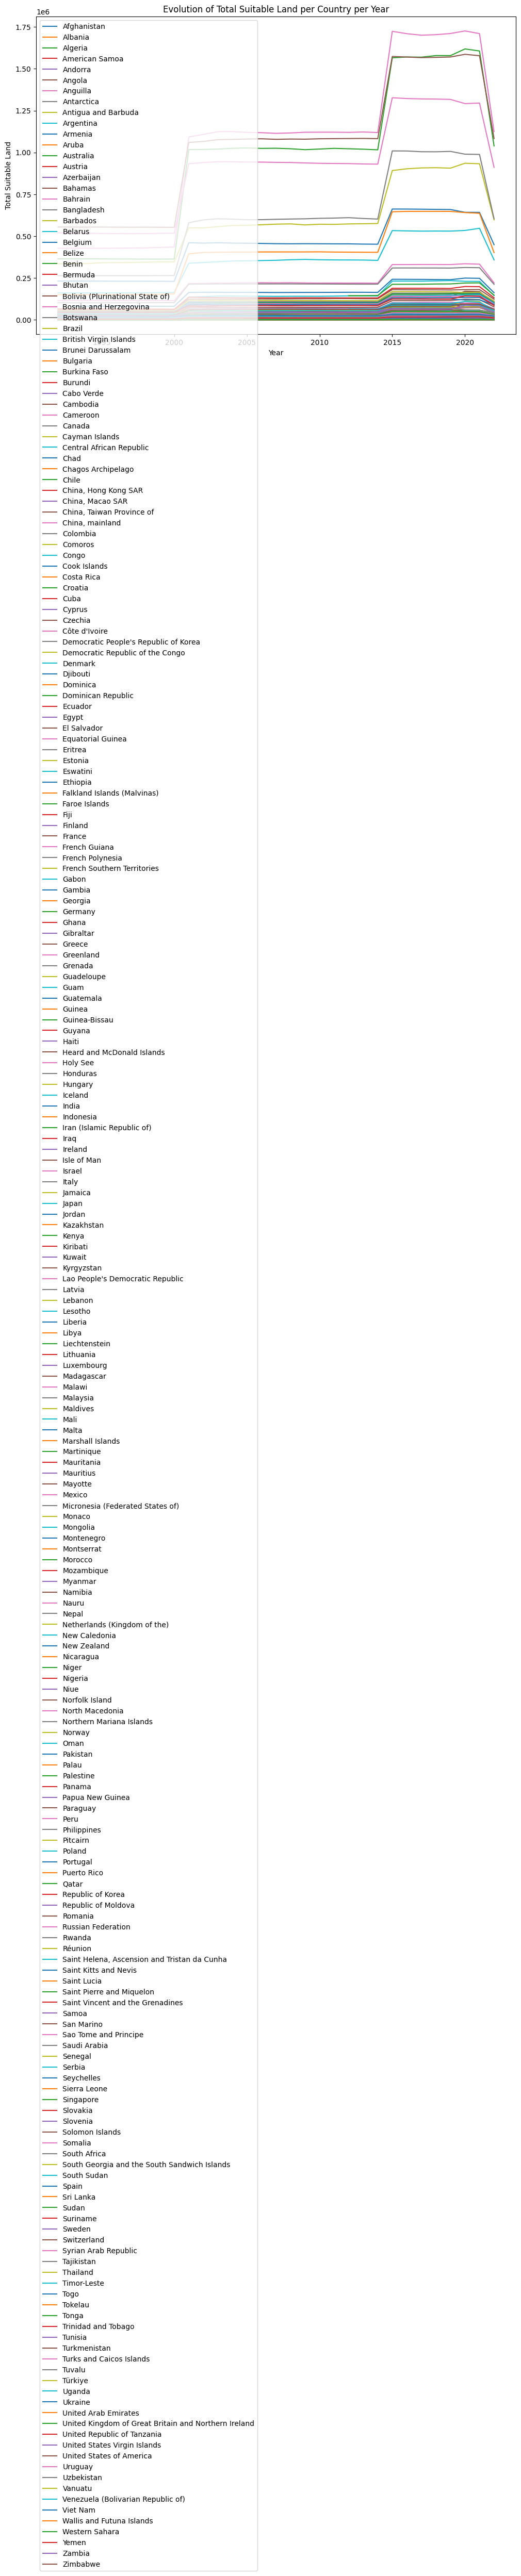

In [58]:
#import mplcursors

plt.figure(figsize=(12, 8))

# Iterate through each country and plot its data
for country in pivoted_suitable_land['Area'].unique():
    country_data = pivoted_suitable_land[pivoted_suitable_land['Area'] == country]
    line, = plt.plot(country_data['Year'], country_data['Total Suitable Land'], label=country)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Total Suitable Land')
plt.title('Evolution of Total Suitable Land per Country per Year')
plt.legend()

# Add interactive cursor
cursor = mplcursors.cursor(hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(sel.artist.get_label()))

# Add legend at the bottom with multiple columns
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)

plt.show()

In [ ]:
pivoted_suitable_land["Year"].min()

np.int64(1992)

In [ ]:
pivoted_suitable_land[pivoted_suitable_land["Year"]==1992]["Area"].nunique()

226

In [ ]:
pivoted_suitable_land = pivoted_suitable_land[pivoted_suitable_land["Year"]==1992]
pivoted_suitable_land = pivoted_suitable_land[["Area", "iso3", "Total Suitable Land"]]
pivoted_suitable_land = pivoted_suitable_land.dropna()
pivoted_suitable_land.isnull().sum()

Item
Area                   0
iso3                   0
Total Suitable Land    0
dtype: int64

In [ ]:
pivoted_suitable_land.reset_index(drop = True, inplace = True)
pivoted_suitable_land.head()

Item,Area,iso3,Total Suitable Land
0,Afghanistan,AFG,33149.29
1,Albania,ALB,1710.49
2,Algeria,DZA,11258.87
3,American Samoa,ASM,5.14
4,Andorra,AND,11.56


In [ ]:
pivoted_suitable_land.rename(columns={'Area': 'Country'}, inplace=True)

In [ ]:
end_df = last_df

In [ ]:
df_final = pd.merge(last_df, pivoted_suitable_land, on=['iso3'], how='outer')
df_final1 = pd.merge(df_final,forests,on=['iso3', 'Year'], how='outer')
df_final1['Total Size Land suitable for corn expansion (sq km)'] = (df_final1['Total Suitable Land']-df_final1['corn1992'])
df_final1 = df_final1.drop(columns=['Total Suitable Land'])
df_final1

,Country_x,Year,landArea,iso3,Total Size Cornfield in ha,Total Size Cornfield in sq km,corn1992,Country_y,Country,Tree-covered areas in sq km,Total Size Land suitable for corn expansion (sq km)
0,NaN,1992.0,NaN,ABW,NaN,NaN,NaN,NaN,Aruba,1.6,NaN
1,NaN,1993.0,NaN,ABW,NaN,NaN,NaN,NaN,Aruba,1.6,NaN
2,NaN,1994.0,NaN,ABW,NaN,NaN,NaN,NaN,Aruba,1.6,NaN
3,NaN,1995.0,NaN,ABW,NaN,NaN,NaN,NaN,Aruba,1.6,NaN
4,NaN,1996.0,NaN,ABW,NaN,NaN,NaN,NaN,Aruba,1.6,NaN
...,...,...,...,...,...,...,...,...,...,...,...
7371,NaN,2019.0,NaN,ZWE,NaN,NaN,NaN,NaN,Zimbabwe,116499.1,NaN
7372,NaN,2020.0,NaN,ZWE,NaN,NaN,NaN,NaN,Zimbabwe,116446.9,NaN
7373,NaN,2021.0,NaN,ZWE,NaN,NaN,NaN,NaN,Zimbabwe,116686.1,NaN
7374,NaN,2022.0,NaN,ZWE,NaN,NaN,NaN,NaN,Zimbabwe,116696.6,NaN


In [ ]:
#let's compare Tree-covered areas and Forest Areas from the other dataset
#df_final1['Forest area (sq km)']=(df_final1['% of Forest Area']/100)*df_final1['landArea']
df_final1['% Land available']=df_final1['Total Size Land suitable for corn expansion (sq km)']/df_final1['landArea']
df_final1=df_final1.dropna()
df_final1

,Country_x,Year,landArea,iso3,Total Size Cornfield in ha,Total Size Cornfield in sq km,corn1992,Country_y,Country,Tree-covered areas in sq km,Total Size Land suitable for corn expansion (sq km),% Land available
40,Afghanistan,2000.0,652230.0,AFG,96000.0,960.00,2000.00,Afghanistan,Afghanistan,12281.1,31149.29,0.047758
41,Afghanistan,2001.0,652230.0,AFG,80000.0,800.00,2000.00,Afghanistan,Afghanistan,11975.3,31149.29,0.047758
42,Afghanistan,2002.0,652230.0,AFG,100000.0,1000.00,2000.00,Afghanistan,Afghanistan,11851.1,31149.29,0.047758
43,Afghanistan,2003.0,652230.0,AFG,250000.0,2500.00,2000.00,Afghanistan,Afghanistan,11735.3,31149.29,0.047758
44,Afghanistan,2004.0,652230.0,AFG,250000.0,2500.00,2000.00,Afghanistan,Afghanistan,11667.1,31149.29,0.047758
...,...,...,...,...,...,...,...,...,...,...,...,...
7338,Zambia,2017.0,743390.0,ZMB,1433944.0,14339.44,6613.05,Zambia,Zambia,473443.9,16982.08,0.022844
7339,Zambia,2018.0,743390.0,ZMB,1086006.0,10860.06,6613.05,Zambia,Zambia,473059.8,16982.08,0.022844
7340,Zambia,2019.0,743390.0,ZMB,841693.0,8416.93,6613.05,Zambia,Zambia,471995.7,16982.08,0.022844
7341,Zambia,2020.0,743390.0,ZMB,1333519.0,13335.19,6613.05,Zambia,Zambia,471548.3,16982.08,0.022844


In [ ]:
df_final1 = df_final1.drop(["Country_y", "Country"], axis=1)
df_final1 = df_final1.rename(columns={"Country_x":"Country"})

In [ ]:
len(df_final1['Country'].unique())

78

In [ ]:
last_df=df_final1

In [ ]:
# Filter the DataFrame for countries with values under 0
countries_with_negative_values = last_df[last_df['Total Size Land suitable for corn expansion (sq km)'] < 0]["Country"].unique()

# Convert to list and print
countries_with_negative_values_list = countries_with_negative_values.tolist()

print(countries_with_negative_values_list)

['Egypt', 'Croatia', 'Hungary', 'Moldova', 'Malawi', 'Nepal', 'Philippines', 'Romania', 'El Salvador', 'Slovenia']


### Corn Price Data

**Corn Price per bushel ($)**: The international corn futures data requires higher-level access but the time series behave identically.

In [ ]:
corn_price_data = pd.read_csv(filepath + "corn-prices-historical-chart-data.csv",skiprows=15)
corn_price_data['date'] = pd.to_datetime(corn_price_data['date'],format='mixed')
corn_price_data = corn_price_data[corn_price_data['date'].dt.year >= 2000]
yearly_price_data = corn_price_data.resample('Y', on='date').last()
yearly_price_data.index = yearly_price_data.index.year
yearly_price_data = (
    yearly_price_data
    .reset_index()  # Reset the index to make it a column
)

# Strip white spaces from column names
yearly_price_data.columns = yearly_price_data.columns.str.strip()

# Rename the columns
yearly_price_data = yearly_price_data.rename(columns={"date": "Year", "value": "Corn_Price_Per_Bushel"})
yearly_price_data.head()

/var/folders/z1/yry6nb4j25bg_5n5f28yn9zw0000gn/T/ipykernel_219/1460633811.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_price_data = corn_price_data.resample('Y', on='date').last()


,Year,Corn_Price_Per_Bushel
0,2000,2.3175
1,2001,2.0900
2,2002,2.3575
3,2003,2.4600
4,2004,2.0475


In [ ]:
yearly_price_data.columns

Index(['Year', 'Corn_Price_Per_Bushel'], dtype='object')

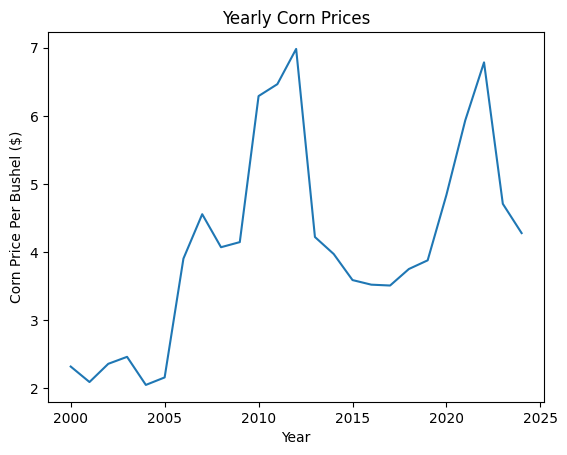

In [ ]:
# Plot the yearly price data
yearly_price_data.set_index(["Year"]).plot(label="Corn Price Per Bushel ($)", legend=False)

# Add labels and title
plt.xlabel("Year")  # X-axis label
plt.ylabel("Corn Price Per Bushel ($)")  # Y-axis label

# Show the plot
plt.title("Yearly Corn Prices")  # Optional: Add a title for the plot
plt.show()

In [ ]:
last_df = pd.merge(last_df, yearly_price_data, on  = "Year" , how = "left")
last_df.head()

,Country,Year,landArea,iso3,Total Size Cornfield in ha,Total Size Cornfield in sq km,corn1992,Tree-covered areas in sq km,Total Size Land suitable for corn expansion (sq km),% Land available,Corn_Price_Per_Bushel
0,Afghanistan,2000.0,652230.0,AFG,96000.0,960.0,2000.0,12281.1,31149.29,0.047758,2.3175
1,Afghanistan,2001.0,652230.0,AFG,80000.0,800.0,2000.0,11975.3,31149.29,0.047758,2.0900
2,Afghanistan,2002.0,652230.0,AFG,100000.0,1000.0,2000.0,11851.1,31149.29,0.047758,2.3575
3,Afghanistan,2003.0,652230.0,AFG,250000.0,2500.0,2000.0,11735.3,31149.29,0.047758,2.4600
4,Afghanistan,2004.0,652230.0,AFG,250000.0,2500.0,2000.0,11667.1,31149.29,0.047758,2.0475


### Delta T

In [ ]:
temp_data = pd.read_csv(filepath + "FAO_Temperature.csv")
temp_data = temp_data[temp_data["Months"] == "Meteorological year"]
temp_data = temp_data[temp_data['Year'] >= 2000]
temp_data = temp_data[temp_data['Year'] <= 2021]
temp_data = temp_data.dropna()
temp_data

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Months Code,Months,Year Code,Year,Unit,Value,Flag,Flag Description
1047,ET,Temperature change on land,4,Afghanistan,7271,Temperature change,7020,Meteorological year,2000,2000,°c,1.064,E,Estimated value
1048,ET,Temperature change on land,4,Afghanistan,7271,Temperature change,7020,Meteorological year,2001,2001,°c,1.377,E,Estimated value
1049,ET,Temperature change on land,4,Afghanistan,7271,Temperature change,7020,Meteorological year,2002,2002,°c,1.457,E,Estimated value
1050,ET,Temperature change on land,4,Afghanistan,7271,Temperature change,7020,Meteorological year,2003,2003,°c,0.710,E,Estimated value
1051,ET,Temperature change on land,4,Afghanistan,7271,Temperature change,7020,Meteorological year,2004,2004,°c,1.482,E,Estimated value
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241886,ET,Temperature change on land,716,Zimbabwe,7271,Temperature change,7020,Meteorological year,2017,2017,°c,0.243,E,Estimated value
241887,ET,Temperature change on land,716,Zimbabwe,7271,Temperature change,7020,Meteorological year,2018,2018,°c,0.636,E,Estimated value
241888,ET,Temperature change on land,716,Zimbabwe,7271,Temperature change,7020,Meteorological year,2019,2019,°c,1.199,E,Estimated value
241889,ET,Temperature change on land,716,Zimbabwe,7271,Temperature change,7020,Meteorological year,2020,2020,°c,0.581,E,Estimated value


In [ ]:
value_counts_per_area = temp_data.groupby("Area")["Value"].count()

area_not_equal_to_22 = value_counts_per_area[value_counts_per_area !=22].index
area_not_equal_to_22

Index(['American Samoa', 'Anguilla', 'Antigua and Barbuda', 'Aruba', 'Burundi',
       'Cabo Verde', 'Cayman Islands', 'Christmas Island', 'Costa Rica',
       'Djibouti', 'Dominica', 'Eritrea', 'Guadeloupe', 'Kiribati',
       'Midway Island', 'Montenegro', 'Montserrat',
       'Netherlands Antilles (former)', 'Norfolk Island', 'Palau', 'Pitcairn',
       'Puerto Rico', 'Rwanda', 'Réunion', 'Saint Kitts and Nevis', 'Samoa',
       'Serbia', 'Serbia and Montenegro', 'Sierra Leone', 'Singapore',
       'Solomon Islands', 'South Georgia and the South Sandwich Islands',
       'South Sudan', 'Sudan', 'Sudan (former)', 'Timor-Leste',
       'United States Virgin Islands', 'Wake Island'],
      dtype='object', name='Area')

In [ ]:
temp_data = temp_data[~temp_data["Area"].isin(area_not_equal_to_22)]
temp_data = temp_data[['Area', 'Year', 'Value']]
temp_data

,Area,Year,Value
1047,Afghanistan,2000,1.064
1048,Afghanistan,2001,1.377
1049,Afghanistan,2002,1.457
1050,Afghanistan,2003,0.710
1051,Afghanistan,2004,1.482
...,...,...,...
241886,Zimbabwe,2017,0.243
241887,Zimbabwe,2018,0.636
241888,Zimbabwe,2019,1.199
241889,Zimbabwe,2020,0.581


In [ ]:
temp_data['iso3'] = temp_data['Area'].apply(get_iso3)
temp_data[temp_data['iso3'].isnull()]["Area"].unique()

array(['Bolivia (Plurinational State of)', 'Channel Islands',
       'China, Hong Kong SAR', 'China, Macao SAR', 'China, mainland',
       'China, Taiwan Province of', 'Democratic Republic of the Congo',
       'Holy See', 'Iran (Islamic Republic of)',
       'Micronesia (Federated States of)', 'Netherlands (Kingdom of the)',
       'Palestine', 'Republic of Korea', 'Svalbard and Jan Mayen Islands',
       'Venezuela (Bolivarian Republic of)', 'Wallis and Futuna Islands'],
      dtype=object)

In [ ]:
country_mapping_temp = {
    'Bolivia (Plurinational State of)':'Bolivia, Plurinational State of',
    'China, Taiwan Province of':'Taiwan, Province of China',
    'China': 'China_',
    'China, mainland':'China',
    'Democratic Republic of the Congo':'Congo, The Democratic Republic of the',
    'Iran (Islamic Republic of)':'Iran, Islamic Republic of',
    'Micronesia (Federated States of)': 'Micronesia, Federated States of',
    'Netherlands (Kingdom of the)':'Netherlands',
    'Republic of Korea': 'Korea, Republic of',
    'Venezuela (Bolivarian Republic of)':'Venezuela, Bolivarian Republic of',
    'China, Hong Kong SAR': 'Hong Kong',
    'Holy See':'Holy See (Vatican City State)',
    'Palestine': 'Palestine, State of',
    'Svalbard and Jan Mayen Islands':'Svalbard and Jan Mayen',
    'Wallis and Futuna Islands':'Wallis and Futuna',
    # You can add more mappings if necessary
}

temp_data['Area'] = temp_data['Area'].replace(country_mapping_temp)
temp_data['iso3'] = temp_data['Area'].apply(get_iso3)
temp_data[temp_data['iso3'].isnull()]["Area"].unique()

array(['Channel Islands', 'China_', 'China, Macao SAR'], dtype=object)

In [ ]:
temp_data = temp_data.dropna()
temp_data = temp_data.reset_index()
temp_data.drop('index', axis=1, inplace=True)
temp_data.rename(columns={'Area':'Country', 'Value':'Temperature Change'}, inplace=True)
temp_data

,Country,Year,Temperature Change,iso3
0,Afghanistan,2000,1.064,AFG
1,Afghanistan,2001,1.377,AFG
2,Afghanistan,2002,1.457,AFG
3,Afghanistan,2003,0.710,AFG
4,Afghanistan,2004,1.482,AFG
...,...,...,...,...
4241,Zimbabwe,2017,0.243,ZWE
4242,Zimbabwe,2018,0.636,ZWE
4243,Zimbabwe,2019,1.199,ZWE
4244,Zimbabwe,2020,0.581,ZWE


In [ ]:
last_df = pd.merge(last_df,temp_data, on=['iso3','Year'], how='outer')
last_df = last_df.drop(["Country_y"], axis=1)
last_df

,Country_x,Year,landArea,iso3,Total Size Cornfield in ha,Total Size Cornfield in sq km,corn1992,Tree-covered areas in sq km,Total Size Land suitable for corn expansion (sq km),% Land available,Corn_Price_Per_Bushel,Temperature Change
0,Afghanistan,2000.0,652230.0,AFG,96000.0,960.0,2000.0,12281.1,31149.29,0.047758,2.3175,1.064
1,Afghanistan,2001.0,652230.0,AFG,80000.0,800.0,2000.0,11975.3,31149.29,0.047758,2.0900,1.377
2,Afghanistan,2002.0,652230.0,AFG,100000.0,1000.0,2000.0,11851.1,31149.29,0.047758,2.3575,1.457
3,Afghanistan,2003.0,652230.0,AFG,250000.0,2500.0,2000.0,11735.3,31149.29,0.047758,2.4600,0.710
4,Afghanistan,2004.0,652230.0,AFG,250000.0,2500.0,2000.0,11667.1,31149.29,0.047758,2.0475,1.482
...,...,...,...,...,...,...,...,...,...,...,...,...
4285,NaN,2017.0,NaN,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.243
4286,NaN,2018.0,NaN,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.636
4287,NaN,2019.0,NaN,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.199
4288,NaN,2020.0,NaN,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.581


In [ ]:
last_df = last_df.rename(columns={'Country_x':'Country'})

In [ ]:
last_df = last_df.dropna()
last_df = last_df.reset_index()
last_df.drop('index', axis=1, inplace=True)
last_df

,Country,Year,landArea,iso3,Total Size Cornfield in ha,Total Size Cornfield in sq km,corn1992,Tree-covered areas in sq km,Total Size Land suitable for corn expansion (sq km),% Land available,Corn_Price_Per_Bushel,Temperature Change
0,Afghanistan,2000.0,652230.0,AFG,96000.0,960.00,2000.00,12281.1,31149.29,0.047758,2.3175,1.064
1,Afghanistan,2001.0,652230.0,AFG,80000.0,800.00,2000.00,11975.3,31149.29,0.047758,2.0900,1.377
2,Afghanistan,2002.0,652230.0,AFG,100000.0,1000.00,2000.00,11851.1,31149.29,0.047758,2.3575,1.457
3,Afghanistan,2003.0,652230.0,AFG,250000.0,2500.00,2000.00,11735.3,31149.29,0.047758,2.4600,0.710
4,Afghanistan,2004.0,652230.0,AFG,250000.0,2500.00,2000.00,11667.1,31149.29,0.047758,2.0475,1.482
...,...,...,...,...,...,...,...,...,...,...,...,...
1667,Zambia,2017.0,743390.0,ZMB,1433944.0,14339.44,6613.05,473443.9,16982.08,0.022844,3.5075,0.579
1668,Zambia,2018.0,743390.0,ZMB,1086006.0,10860.06,6613.05,473059.8,16982.08,0.022844,3.7500,0.998
1669,Zambia,2019.0,743390.0,ZMB,841693.0,8416.93,6613.05,471995.7,16982.08,0.022844,3.8775,1.349
1670,Zambia,2020.0,743390.0,ZMB,1333519.0,13335.19,6613.05,471548.3,16982.08,0.022844,4.8400,1.386


### Average Temperature

Source: https://ourworldindata.org/grapher/monthly-average-surface-temperatures-by-year

In [ ]:
avg_temp_df = pd.read_csv(filepath + "monthly-average-surface-temperatures-by-year.csv")
avg_temp_df = avg_temp_df.drop(["Year"], axis = 1)
avg_temp_df = (avg_temp_df
               .groupby(by = ["Entity","Code"])
               .mean()
               .reset_index())
avg_temp_df = pd.melt(
    avg_temp_df,
    id_vars=["Entity", "Code"],  # Keep these columns fixed
    var_name="Reported_Year",    # Avoid using "Year" to prevent conflicts
    value_name="Temperature"     # Rename the values column
)

# Convert Reported_Year to integer
avg_temp_df["Reported_Year"] = avg_temp_df["Reported_Year"].astype(int)

# Apply the query with numeric comparison
avg_temp_df = (avg_temp_df
               .query("2000 <= Reported_Year <= 2021")
               .rename(columns = {"Temperature":"Average_Temperature",
                                  "Code":"iso3",
                                  "Reported_Year" : "Year"}))
avg_temp_df.head()

,Entity,iso3,Year,Average_Temperature
585,Afghanistan,AFG,2021,13.982914
586,Albania,ALB,2021,13.125356
587,Algeria,DZA,2021,25.220117
588,American Samoa,ASM,2021,26.756304
589,Andorra,AND,2021,5.152789


In [ ]:
last_df = pd.merge(last_df,avg_temp_df,on = ["iso3","Year"],how = "left")
last_df.head()

,Country,Year,landArea,iso3,Total Size Cornfield in ha,Total Size Cornfield in sq km,corn1992,Tree-covered areas in sq km,Total Size Land suitable for corn expansion (sq km),% Land available,Corn_Price_Per_Bushel,Temperature Change,Entity,Average_Temperature
0,Afghanistan,2000.0,652230.0,AFG,96000.0,960.0,2000.0,12281.1,31149.29,0.047758,2.3175,1.064,Afghanistan,12.586175
1,Afghanistan,2001.0,652230.0,AFG,80000.0,800.0,2000.0,11975.3,31149.29,0.047758,2.0900,1.377,Afghanistan,13.413867
2,Afghanistan,2002.0,652230.0,AFG,100000.0,1000.0,2000.0,11851.1,31149.29,0.047758,2.3575,1.457,Afghanistan,13.051083
3,Afghanistan,2003.0,652230.0,AFG,250000.0,2500.0,2000.0,11735.3,31149.29,0.047758,2.4600,0.710,Afghanistan,12.485457
4,Afghanistan,2004.0,652230.0,AFG,250000.0,2500.0,2000.0,11667.1,31149.29,0.047758,2.0475,1.482,Afghanistan,13.233360


In [ ]:
last_df = last_df.drop(["Entity"], axis=1)
last_df

,Country,Year,landArea,iso3,Total Size Cornfield in ha,Total Size Cornfield in sq km,corn1992,Tree-covered areas in sq km,Total Size Land suitable for corn expansion (sq km),% Land available,Corn_Price_Per_Bushel,Temperature Change,Average_Temperature
0,Afghanistan,2000.0,652230.0,AFG,96000.0,960.00,2000.00,12281.1,31149.29,0.047758,2.3175,1.064,12.586175
1,Afghanistan,2001.0,652230.0,AFG,80000.0,800.00,2000.00,11975.3,31149.29,0.047758,2.0900,1.377,13.413867
2,Afghanistan,2002.0,652230.0,AFG,100000.0,1000.00,2000.00,11851.1,31149.29,0.047758,2.3575,1.457,13.051083
3,Afghanistan,2003.0,652230.0,AFG,250000.0,2500.00,2000.00,11735.3,31149.29,0.047758,2.4600,0.710,12.485457
4,Afghanistan,2004.0,652230.0,AFG,250000.0,2500.00,2000.00,11667.1,31149.29,0.047758,2.0475,1.482,13.233360
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667,Zambia,2017.0,743390.0,ZMB,1433944.0,14339.44,6613.05,473443.9,16982.08,0.022844,3.5075,0.579,21.990675
1668,Zambia,2018.0,743390.0,ZMB,1086006.0,10860.06,6613.05,473059.8,16982.08,0.022844,3.7500,0.998,22.302766
1669,Zambia,2019.0,743390.0,ZMB,841693.0,8416.93,6613.05,471995.7,16982.08,0.022844,3.8775,1.349,22.617600
1670,Zambia,2020.0,743390.0,ZMB,1333519.0,13335.19,6613.05,471548.3,16982.08,0.022844,4.8400,1.386,22.167939


### GDP

In [ ]:
gdp_data = pd.read_csv(filepath + "FAOSTAT_GDP.csv")
gdp_data = gdp_data[gdp_data['Year'] >= 2000]
gdp_data = gdp_data[gdp_data['Year'] <= 2021]
gdp_data.drop('Note', axis=1, inplace=True)
gdp_data = gdp_data.dropna()
gdp_data

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
30,MK,Macro Indicators,4,Afghanistan,6110,Value US$,22008,Gross Domestic Product,2000,2000,million USD,3531.869351,X,Figure from international organizations
31,MK,Macro Indicators,4,Afghanistan,6110,Value US$,22008,Gross Domestic Product,2001,2001,million USD,3620.525250,X,Figure from international organizations
32,MK,Macro Indicators,4,Afghanistan,6110,Value US$,22008,Gross Domestic Product,2002,2002,million USD,4285.191376,X,Figure from international organizations
33,MK,Macro Indicators,4,Afghanistan,6110,Value US$,22008,Gross Domestic Product,2003,2003,million USD,4898.791114,X,Figure from international organizations
34,MK,Macro Indicators,4,Afghanistan,6110,Value US$,22008,Gross Domestic Product,2004,2004,million USD,5504.073142,X,Figure from international organizations
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10865,MK,Macro Indicators,716,Zimbabwe,6110,Value US$,22008,Gross Domestic Product,2017,2017,million USD,22040.654699,X,Figure from international organizations
10866,MK,Macro Indicators,716,Zimbabwe,6110,Value US$,22008,Gross Domestic Product,2018,2018,million USD,23645.265549,X,Figure from international organizations
10867,MK,Macro Indicators,716,Zimbabwe,6110,Value US$,22008,Gross Domestic Product,2019,2019,million USD,22594.520375,X,Figure from international organizations
10868,MK,Macro Indicators,716,Zimbabwe,6110,Value US$,22008,Gross Domestic Product,2020,2020,million USD,21664.745864,X,Figure from international organizations


In [ ]:
value_counts_per_area = gdp_data.groupby("Area")["Value"].count()

area_not_equal_to_22 = value_counts_per_area[value_counts_per_area !=22].index
area_not_equal_to_22

Index(['Curaçao', 'Netherlands Antilles (former)', 'Sint Maarten (Dutch part)',
       'South Sudan', 'Sudan', 'Sudan (former)'],
      dtype='object', name='Area')

In [ ]:
gdp_data = gdp_data[~gdp_data["Area"].isin(area_not_equal_to_22)]
gdp_data = gdp_data[['Area', 'Year', 'Value']]
gdp_data

,Area,Year,Value
30,Afghanistan,2000,3531.869351
31,Afghanistan,2001,3620.525250
32,Afghanistan,2002,4285.191376
33,Afghanistan,2003,4898.791114
34,Afghanistan,2004,5504.073142
...,...,...,...
10865,Zimbabwe,2017,22040.654699
10866,Zimbabwe,2018,23645.265549
10867,Zimbabwe,2019,22594.520375
10868,Zimbabwe,2020,21664.745864


In [ ]:
gdp_data['iso3'] = gdp_data['Area'].apply(get_iso3)
gdp_data[gdp_data['iso3'].isnull()]["Area"].unique()

array(['Bolivia (Plurinational State of)', 'China, Hong Kong SAR',
       'China, Macao SAR', 'China, mainland',
       'Democratic Republic of the Congo', 'Iran (Islamic Republic of)',
       'Micronesia (Federated States of)', 'Netherlands (Kingdom of the)',
       'Palestine', 'Republic of Korea',
       'Venezuela (Bolivarian Republic of)'], dtype=object)

In [ ]:
country_mapping_temp = {
    'Bolivia (Plurinational State of)':'Bolivia, Plurinational State of',
    'China, Taiwan Province of':'Taiwan, Province of China',
    'China': 'China_',
    'China, mainland':'China',
    'Democratic Republic of the Congo':'Congo, The Democratic Republic of the',
    'Iran (Islamic Republic of)':'Iran, Islamic Republic of',
    'Micronesia (Federated States of)': 'Micronesia, Federated States of',
    'Netherlands (Kingdom of the)':'Netherlands',
    'Republic of Korea': 'Korea, Republic of',
    'Venezuela (Bolivarian Republic of)':'Venezuela, Bolivarian Republic of',
    'China, Hong Kong SAR': 'Hong Kong',
    'Palestine': 'Palestine, State of',
    # You can add more mappings if necessary
}

gdp_data['Area'] = gdp_data['Area'].replace(country_mapping_temp)
gdp_data['iso3'] = gdp_data['Area'].apply(get_iso3)
gdp_data[gdp_data['iso3'].isnull()]["Area"].unique()

array(['China_', 'China, Macao SAR'], dtype=object)

In [ ]:
gdp_data = gdp_data.dropna()
gdp_data = gdp_data.reset_index()
gdp_data.drop('index', axis=1, inplace=True)
gdp_data.rename(columns={'Area':'Country', 'Value':'GDP'}, inplace=True)
gdp_data

,Country,Year,GDP,iso3
0,Afghanistan,2000,3531.869351,AFG
1,Afghanistan,2001,3620.525250,AFG
2,Afghanistan,2002,4285.191376,AFG
3,Afghanistan,2003,4898.791114,AFG
4,Afghanistan,2004,5504.073142,AFG
...,...,...,...,...
4505,Zimbabwe,2017,22040.654699,ZWE
4506,Zimbabwe,2018,23645.265549,ZWE
4507,Zimbabwe,2019,22594.520375,ZWE
4508,Zimbabwe,2020,21664.745864,ZWE


In [ ]:
last_df = pd.merge(last_df,gdp_data, on=['iso3','Year'], how='outer')
last_df = last_df.drop(["Country_y"], axis=1)
last_df

,Country_x,Year,landArea,iso3,Total Size Cornfield in ha,Total Size Cornfield in sq km,corn1992,Tree-covered areas in sq km,Total Size Land suitable for corn expansion (sq km),% Land available,Corn_Price_Per_Bushel,Temperature Change,Average_Temperature,GDP
0,NaN,2000.0,NaN,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1873.452514
1,NaN,2001.0,NaN,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1896.456983
2,NaN,2002.0,NaN,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1961.843575
3,NaN,2003.0,NaN,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2044.111732
4,NaN,2004.0,NaN,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2254.830726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4505,NaN,2017.0,NaN,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22040.654699
4506,NaN,2018.0,NaN,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23645.265549
4507,NaN,2019.0,NaN,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22594.520375
4508,NaN,2020.0,NaN,ZWE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21664.745864


In [ ]:
last_df = last_df.rename(columns={'Country_x':'Country'})
last_df = last_df.dropna()
last_df = last_df.reset_index()
last_df.drop('index', axis=1, inplace=True)
last_df

,Country,Year,landArea,iso3,Total Size Cornfield in ha,Total Size Cornfield in sq km,corn1992,Tree-covered areas in sq km,Total Size Land suitable for corn expansion (sq km),% Land available,Corn_Price_Per_Bushel,Temperature Change,Average_Temperature,GDP
0,Afghanistan,2000.0,652230.0,AFG,96000.0,960.00,2000.00,12281.1,31149.29,0.047758,2.3175,1.064,12.586175,3531.869351
1,Afghanistan,2001.0,652230.0,AFG,80000.0,800.00,2000.00,11975.3,31149.29,0.047758,2.0900,1.377,13.413867,3620.525250
2,Afghanistan,2002.0,652230.0,AFG,100000.0,1000.00,2000.00,11851.1,31149.29,0.047758,2.3575,1.457,13.051083,4285.191376
3,Afghanistan,2003.0,652230.0,AFG,250000.0,2500.00,2000.00,11735.3,31149.29,0.047758,2.4600,0.710,12.485457,4898.791114
4,Afghanistan,2004.0,652230.0,AFG,250000.0,2500.00,2000.00,11667.1,31149.29,0.047758,2.0475,1.482,13.233360,5504.073142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667,Zambia,2017.0,743390.0,ZMB,1433944.0,14339.44,6613.05,473443.9,16982.08,0.022844,3.5075,0.579,21.990675,25895.263867
1668,Zambia,2018.0,743390.0,ZMB,1086006.0,10860.06,6613.05,473059.8,16982.08,0.022844,3.7500,0.998,22.302766,26311.984274
1669,Zambia,2019.0,743390.0,ZMB,841693.0,8416.93,6613.05,471995.7,16982.08,0.022844,3.8775,1.349,22.617600,23310.346721
1670,Zambia,2020.0,743390.0,ZMB,1333519.0,13335.19,6613.05,471548.3,16982.08,0.022844,4.8400,1.386,22.167939,18063.780790


In [ ]:
last_df["Country"].nunique()

76

### Rainfall
Source: https://data.worldbank.org/indicator/AG.LND.PRCP.MM?utm_source=chatgpt.com

**Content of data**:

 - Average precipitation in depth (mm per year)
 - Average precipitation is the long-term average in depth (over space and time) of annual precipitation in the country. Precipitation is defined as any kind of water that falls from clouds as a liquid or a solid.



In [ ]:
rainfall_df = pd.read_excel(filepath + "rainfall_data.xlsx")
rainfall_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Aruba,ABW,Average precipitation in depth (mm per year),AG.LND.PRCP.MM,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,Average precipitation in depth (mm per year),AG.LND.PRCP.MM,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,Average precipitation in depth (mm per year),AG.LND.PRCP.MM,NaN,327.0,327.0,327.0,327.0,327.0,...,327.0,327.0,327.0,327.0,327.0,327.0,327.0,327.0,NaN,NaN
3,Africa Western and Central,AFW,Average precipitation in depth (mm per year),AG.LND.PRCP.MM,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,AGO,Average precipitation in depth (mm per year),AG.LND.PRCP.MM,NaN,1010.0,1010.0,1010.0,1010.0,1010.0,...,1010.0,1010.0,1010.0,1010.0,1010.0,1010.0,1010.0,1010.0,NaN,NaN


In [ ]:
rainfall_df_new = rainfall_df.drop(["Country Name","Indicator Name","Indicator Code"], axis =1)

adj_rainfall_df = (pd.melt(rainfall_df_new,
    id_vars=["Country Code"],  # Keep these columns fixed
    var_name="Year",    # Avoid using "Year" to prevent conflicts
    value_name="rain" )
    .sort_values(["Country Code","Year"])
    .reset_index(drop = True)
    .rename(columns = {"Country Code" : "iso3"}))

adj_rainfall_df["Year"] = adj_rainfall_df["Year"].astype('int64') 

adj_rainfall_df.head()

,iso3,Year,rain
0,ABW,1960,NaN
1,ABW,1961,NaN
2,ABW,1962,NaN
3,ABW,1963,NaN
4,ABW,1964,NaN


In [ ]:
adj_rainfall_df = adj_rainfall_df[adj_rainfall_df['Year'] >= 2000]
adj_rainfall_df = adj_rainfall_df[adj_rainfall_df['Year'] <= 2021]
adj_rainfall_df = adj_rainfall_df.dropna()
adj_rainfall_df.head()

,iso3,Year,rain
168,AFG,2000,327.0
169,AFG,2001,327.0
170,AFG,2002,327.0
171,AFG,2003,327.0
172,AFG,2004,327.0


In [ ]:
value_counts_per_area = adj_rainfall_df.groupby("iso3")["rain"].count()

areas_not_equal_to_22 = value_counts_per_area[value_counts_per_area != 22].index
areas_not_equal_to_22

Index(['SDN', 'SSD'], dtype='object', name='iso3')

In [ ]:
adj_rainfall_df = adj_rainfall_df[~adj_rainfall_df["iso3"].isin(areas_not_equal_to_22)]
adj_rainfall_df.head()

,iso3,Year,rain
168,AFG,2000,327.0
169,AFG,2001,327.0
170,AFG,2002,327.0
171,AFG,2003,327.0
172,AFG,2004,327.0


In [ ]:
last_df = pd.merge(last_df, adj_rainfall_df, on=['iso3', 'Year'], how='outer')
last_df = last_df.dropna()
last_df

,Country,Year,landArea,iso3,Total Size Cornfield in ha,Total Size Cornfield in sq km,corn1992,Tree-covered areas in sq km,Total Size Land suitable for corn expansion (sq km),% Land available,Corn_Price_Per_Bushel,Temperature Change,Average_Temperature,GDP,rain
0,Afghanistan,2000.0,652230.0,AFG,96000.0,960.00,2000.00,12281.1,31149.29,0.047758,2.3175,1.064,12.586175,3531.869351,327.0
1,Afghanistan,2001.0,652230.0,AFG,80000.0,800.00,2000.00,11975.3,31149.29,0.047758,2.0900,1.377,13.413867,3620.525250,327.0
2,Afghanistan,2002.0,652230.0,AFG,100000.0,1000.00,2000.00,11851.1,31149.29,0.047758,2.3575,1.457,13.051083,4285.191376,327.0
3,Afghanistan,2003.0,652230.0,AFG,250000.0,2500.00,2000.00,11735.3,31149.29,0.047758,2.4600,0.710,12.485457,4898.791114,327.0
4,Afghanistan,2004.0,652230.0,AFG,250000.0,2500.00,2000.00,11667.1,31149.29,0.047758,2.0475,1.482,13.233360,5504.073142,327.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3933,Zambia,2017.0,743390.0,ZMB,1433944.0,14339.44,6613.05,473443.9,16982.08,0.022844,3.5075,0.579,21.990675,25895.263867,1020.0
3934,Zambia,2018.0,743390.0,ZMB,1086006.0,10860.06,6613.05,473059.8,16982.08,0.022844,3.7500,0.998,22.302766,26311.984274,1020.0
3935,Zambia,2019.0,743390.0,ZMB,841693.0,8416.93,6613.05,471995.7,16982.08,0.022844,3.8775,1.349,22.617600,23310.346721,1020.0
3936,Zambia,2020.0,743390.0,ZMB,1333519.0,13335.19,6613.05,471548.3,16982.08,0.022844,4.8400,1.386,22.167939,18063.780790,1020.0


### Corruption
#### The Bayesian Corruption Indicator (bci_bci)

In [ ]:
bci = pd.read_csv(filepath + "bci_bci.csv", delimiter = ";")

# Convert commas to dots for numeric columns
for col in bci.columns:
    if bci[col].dtype == 'object':
        try:
            bci[col] = pd.to_numeric(bci[col].str.replace(',', '.'), errors='raise')
        except ValueError:
            pass
bci 

,ccode,cname,year,ccode_qog,cname_qog,ccodealp,ccodecow,version,cname_year,ccodealp_year,bci_bci
0,4,Afghanistan,1996,4,Afghanistan,AFG,700.0,QoGStdTSjan24,Afghanistan 1996,AFG96,63.57
1,4,Afghanistan,1997,4,Afghanistan,AFG,700.0,QoGStdTSjan24,Afghanistan 1997,AFG97,63.40
2,4,Afghanistan,1998,4,Afghanistan,AFG,700.0,QoGStdTSjan24,Afghanistan 1998,AFG98,63.15
3,4,Afghanistan,1999,4,Afghanistan,AFG,700.0,QoGStdTSjan24,Afghanistan 1999,AFG99,62.99
4,4,Afghanistan,2000,4,Afghanistan,AFG,700.0,QoGStdTSjan24,Afghanistan 2000,AFG00,62.77
...,...,...,...,...,...,...,...,...,...,...,...
6331,894,Zambia,2017,894,Zambia,ZMB,551.0,QoGStdTSjan24,Zambia 2017,ZMB17,58.19
6332,894,Zambia,2018,894,Zambia,ZMB,551.0,QoGStdTSjan24,Zambia 2018,ZMB18,57.68
6333,894,Zambia,2019,894,Zambia,ZMB,551.0,QoGStdTSjan24,Zambia 2019,ZMB19,57.25
6334,894,Zambia,2020,894,Zambia,ZMB,551.0,QoGStdTSjan24,Zambia 2020,ZMB20,56.95


In [ ]:
bci = bci[bci["year"]>=2000] 
bci = bci[bci["year"]<=2021]
bci = bci.dropna()
bci

,ccode,cname,year,ccode_qog,cname_qog,ccodealp,ccodecow,version,cname_year,ccodealp_year,bci_bci
4,4,Afghanistan,2000,4,Afghanistan,AFG,700.0,QoGStdTSjan24,Afghanistan 2000,AFG00,62.77
5,4,Afghanistan,2001,4,Afghanistan,AFG,700.0,QoGStdTSjan24,Afghanistan 2001,AFG01,62.67
6,4,Afghanistan,2002,4,Afghanistan,AFG,700.0,QoGStdTSjan24,Afghanistan 2002,AFG02,62.43
7,4,Afghanistan,2003,4,Afghanistan,AFG,700.0,QoGStdTSjan24,Afghanistan 2003,AFG03,62.20
8,4,Afghanistan,2004,4,Afghanistan,AFG,700.0,QoGStdTSjan24,Afghanistan 2004,AFG04,62.01
...,...,...,...,...,...,...,...,...,...,...,...
6331,894,Zambia,2017,894,Zambia,ZMB,551.0,QoGStdTSjan24,Zambia 2017,ZMB17,58.19
6332,894,Zambia,2018,894,Zambia,ZMB,551.0,QoGStdTSjan24,Zambia 2018,ZMB18,57.68
6333,894,Zambia,2019,894,Zambia,ZMB,551.0,QoGStdTSjan24,Zambia 2019,ZMB19,57.25
6334,894,Zambia,2020,894,Zambia,ZMB,551.0,QoGStdTSjan24,Zambia 2020,ZMB20,56.95


In [ ]:
value_counts_per_area = bci.groupby("cname")["bci_bci"].count()

areas_not_equal_to_22 = value_counts_per_area[value_counts_per_area != 22].index
areas_not_equal_to_22

Index(['Cabo Verde', 'Kiribati', 'Marshall Islands',
       'Micronesia (Federated States of)', 'Montenegro', 'Nauru', 'Palau',
       'Saint Kitts and Nevis', 'Saint Lucia',
       'Saint Vincent and the Grenadines', 'Solomon Islands', 'South Sudan',
       'Sudan (the)', 'Timor-Leste', 'Tonga', 'Tuvalu', 'Vanuatu'],
      dtype='object', name='cname')

In [ ]:
bci = bci[~bci["cname"].isin(areas_not_equal_to_22)]
bci = bci[['year', 'ccodealp','bci_bci']]
bci = bci.rename(columns = {"ccodealp":"iso3","year":"Year"})
bci.head()

,Year,iso3,bci_bci
4,2000,AFG,62.77
5,2001,AFG,62.67
6,2002,AFG,62.43
7,2003,AFG,62.20
8,2004,AFG,62.01


In [ ]:
last_df = pd.merge(last_df,bci, on=['iso3','Year'], how='outer')
last_df = last_df.dropna()
last_df

,Country,Year,landArea,iso3,Total Size Cornfield in ha,Total Size Cornfield in sq km,corn1992,Tree-covered areas in sq km,Total Size Land suitable for corn expansion (sq km),% Land available,Corn_Price_Per_Bushel,Temperature Change,Average_Temperature,GDP,rain,bci_bci
0,Afghanistan,2000.0,652230.0,AFG,96000.0,960.00,2000.00,12281.1,31149.29,0.047758,2.3175,1.064,12.586175,3531.869351,327.0,62.77
1,Afghanistan,2001.0,652230.0,AFG,80000.0,800.00,2000.00,11975.3,31149.29,0.047758,2.0900,1.377,13.413867,3620.525250,327.0,62.67
2,Afghanistan,2002.0,652230.0,AFG,100000.0,1000.00,2000.00,11851.1,31149.29,0.047758,2.3575,1.457,13.051083,4285.191376,327.0,62.43
3,Afghanistan,2003.0,652230.0,AFG,250000.0,2500.00,2000.00,11735.3,31149.29,0.047758,2.4600,0.710,12.485457,4898.791114,327.0,62.20
4,Afghanistan,2004.0,652230.0,AFG,250000.0,2500.00,2000.00,11667.1,31149.29,0.047758,2.0475,1.482,13.233360,5504.073142,327.0,62.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3801,Zambia,2017.0,743390.0,ZMB,1433944.0,14339.44,6613.05,473443.9,16982.08,0.022844,3.5075,0.579,21.990675,25895.263867,1020.0,58.19
3802,Zambia,2018.0,743390.0,ZMB,1086006.0,10860.06,6613.05,473059.8,16982.08,0.022844,3.7500,0.998,22.302766,26311.984274,1020.0,57.68
3803,Zambia,2019.0,743390.0,ZMB,841693.0,8416.93,6613.05,471995.7,16982.08,0.022844,3.8775,1.349,22.617600,23310.346721,1020.0,57.25
3804,Zambia,2020.0,743390.0,ZMB,1333519.0,13335.19,6613.05,471548.3,16982.08,0.022844,4.8400,1.386,22.167939,18063.780790,1020.0,56.95


### Rural Population (% of total population)

In [ ]:
pop = pd.read_csv(filepath + "wdi_poprul.csv", delimiter = ";")

# Convert commas to dots for numeric columns
for col in pop.columns:
    if pop[col].dtype == 'object':
        try:
            pop[col] = pd.to_numeric(pop[col].str.replace(',', '.'), errors='raise')
        except ValueError:
            pass
pop 

,ccode,cname,year,ccode_qog,cname_qog,ccodealp,ccodecow,version,cname_year,ccodealp_year,wdi_poprul
0,4,Afghanistan,1960,4,Afghanistan,AFG,700.0,QoGStdTSjan24,Afghanistan 1960,AFG60,91.60
1,4,Afghanistan,1961,4,Afghanistan,AFG,700.0,QoGStdTSjan24,Afghanistan 1961,AFG61,91.32
2,4,Afghanistan,1962,4,Afghanistan,AFG,700.0,QoGStdTSjan24,Afghanistan 1962,AFG62,91.02
3,4,Afghanistan,1963,4,Afghanistan,AFG,700.0,QoGStdTSjan24,Afghanistan 1963,AFG63,90.72
4,4,Afghanistan,1964,4,Afghanistan,AFG,700.0,QoGStdTSjan24,Afghanistan 1964,AFG64,90.41
...,...,...,...,...,...,...,...,...,...,...,...
10485,998,"Vietnam, North",1972,998,"Vietnam, North",VNM,NaN,QoGStdTSjan24,"Vietnam, North 1972",VNM72,81.51
10486,998,"Vietnam, North",1973,998,"Vietnam, North",VNM,NaN,QoGStdTSjan24,"Vietnam, North 1973",VNM73,81.41
10487,998,"Vietnam, North",1974,998,"Vietnam, North",VNM,NaN,QoGStdTSjan24,"Vietnam, North 1974",VNM74,81.31
10488,998,"Vietnam, North",1975,998,"Vietnam, North",VNM,NaN,QoGStdTSjan24,"Vietnam, North 1975",VNM75,81.22


In [ ]:
pop = pop[pop["year"]>=2000] 
pop = pop[pop["year"]<=2021]
pop = pop.dropna()
pop

,ccode,cname,year,ccode_qog,cname_qog,ccodealp,ccodecow,version,cname_year,ccodealp_year,wdi_poprul
40,4,Afghanistan,2000,4,Afghanistan,AFG,700.0,QoGStdTSjan24,Afghanistan 2000,AFG00,77.92
41,4,Afghanistan,2001,4,Afghanistan,AFG,700.0,QoGStdTSjan24,Afghanistan 2001,AFG01,77.83
42,4,Afghanistan,2002,4,Afghanistan,AFG,700.0,QoGStdTSjan24,Afghanistan 2002,AFG02,77.74
43,4,Afghanistan,2003,4,Afghanistan,AFG,700.0,QoGStdTSjan24,Afghanistan 2003,AFG03,77.65
44,4,Afghanistan,2004,4,Afghanistan,AFG,700.0,QoGStdTSjan24,Afghanistan 2004,AFG04,77.50
...,...,...,...,...,...,...,...,...,...,...,...
10436,894,Zambia,2017,894,Zambia,ZMB,551.0,QoGStdTSjan24,Zambia 2017,ZMB17,57.02
10437,894,Zambia,2018,894,Zambia,ZMB,551.0,QoGStdTSjan24,Zambia 2018,ZMB18,56.48
10438,894,Zambia,2019,894,Zambia,ZMB,551.0,QoGStdTSjan24,Zambia 2019,ZMB19,55.93
10439,894,Zambia,2020,894,Zambia,ZMB,551.0,QoGStdTSjan24,Zambia 2020,ZMB20,55.37


In [ ]:
value_counts_per_area = pop.groupby("cname")["wdi_poprul"].count()

areas_not_equal_to_22 = value_counts_per_area[value_counts_per_area != 22].index
areas_not_equal_to_22

Index(['Montenegro', 'South Sudan', 'Sudan (the)', 'Timor-Leste'], dtype='object', name='cname')

In [ ]:
pop = pop[~pop["cname"].isin(areas_not_equal_to_22)]
pop = pop[['year', 'ccodealp','wdi_poprul']]
pop = pop.rename(columns = {"ccodealp":"iso3","year":"Year"})
pop.head()

,Year,iso3,wdi_poprul
40,2000,AFG,77.92
41,2001,AFG,77.83
42,2002,AFG,77.74
43,2003,AFG,77.65
44,2004,AFG,77.50


In [ ]:
last_df = pd.merge(last_df,pop, on=['iso3','Year'], how='outer')
last_df = last_df.dropna()
last_df

,Country,Year,landArea,iso3,Total Size Cornfield in ha,Total Size Cornfield in sq km,corn1992,Tree-covered areas in sq km,Total Size Land suitable for corn expansion (sq km),% Land available,Corn_Price_Per_Bushel,Temperature Change,Average_Temperature,GDP,rain,bci_bci,wdi_poprul
0,Afghanistan,2000.0,652230.0,AFG,96000.0,960.00,2000.00,12281.1,31149.29,0.047758,2.3175,1.064,12.586175,3531.869351,327.0,62.77,77.92
1,Afghanistan,2001.0,652230.0,AFG,80000.0,800.00,2000.00,11975.3,31149.29,0.047758,2.0900,1.377,13.413867,3620.525250,327.0,62.67,77.83
2,Afghanistan,2002.0,652230.0,AFG,100000.0,1000.00,2000.00,11851.1,31149.29,0.047758,2.3575,1.457,13.051083,4285.191376,327.0,62.43,77.74
3,Afghanistan,2003.0,652230.0,AFG,250000.0,2500.00,2000.00,11735.3,31149.29,0.047758,2.4600,0.710,12.485457,4898.791114,327.0,62.20,77.65
4,Afghanistan,2004.0,652230.0,AFG,250000.0,2500.00,2000.00,11667.1,31149.29,0.047758,2.0475,1.482,13.233360,5504.073142,327.0,62.01,77.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4109,Zambia,2017.0,743390.0,ZMB,1433944.0,14339.44,6613.05,473443.9,16982.08,0.022844,3.5075,0.579,21.990675,25895.263867,1020.0,58.19,57.02
4110,Zambia,2018.0,743390.0,ZMB,1086006.0,10860.06,6613.05,473059.8,16982.08,0.022844,3.7500,0.998,22.302766,26311.984274,1020.0,57.68,56.48
4111,Zambia,2019.0,743390.0,ZMB,841693.0,8416.93,6613.05,471995.7,16982.08,0.022844,3.8775,1.349,22.617600,23310.346721,1020.0,57.25,55.93
4112,Zambia,2020.0,743390.0,ZMB,1333519.0,13335.19,6613.05,471548.3,16982.08,0.022844,4.8400,1.386,22.167939,18063.780790,1020.0,56.95,55.37


### Government Eﬀectiveness, Estimate

### Political Stability and Absence of Violence/Terrorism, Estimate

### Global Peace Index

### Rainfall dataset

Source: https://data.worldbank.org/indicator/AG.LND.PRCP.MM?utm_source=chatgpt.com

**Content of data**:

 - Average precipitation in depth (mm per year)
 - Average precipitation is the long-term average in depth (over space and time) of annual precipitation in the country. Precipitation is defined as any kind of water that falls from clouds as a liquid or a solid.



In [ ]:
#rainfall_df = pd.read_excel("./Data/rainfall_data.xls")
#rainfall_df.head()

# COLS Renaming

In [ ]:
last_df.keys()

Index(['Country', 'Year', 'landArea', 'iso3', 'Total Size Cornfield in ha',
       'Total Size Cornfield in sq km', 'corn1992',
       'Tree-covered areas in sq km',
       'Total Size Land suitable for corn expansion (sq km)',
       '% Land available', 'Corn_Price_Per_Bushel', 'Temperature Change',
       'Average_Temperature', 'GDP', 'rain', 'bci_bci', 'wdi_poprul'],
      dtype='object')

In [ ]:
last_df.rename(columns={'Total Size Cornfield in sq km':'corn',
                        'Tree-covered areas in sq km':'forest',
                        'Total Size Land suitable for corn expansion (sq km)':'suitability',
                        'Suitable_Land_Higher_Than_Median':'heterogeneityDummy',
                        'Corn_Price_Per_Bushel':'price',
                        'Temperature Change':'temperature',
                        'Log Corn':'logcorn',
                        'Log Forest':'logforest',
                        'Log Land':'logland',
                        'Year':'year',
                        'Country':'country',
                        'GDP':'gdp'},inplace=True)

In [ ]:
last_df.keys()

Index(['country', 'year', 'landArea', 'iso3', 'Total Size Cornfield in ha',
       'corn', 'corn1992', 'forest', 'suitability', '% Land available',
       'price', 'temperature', 'Average_Temperature', 'gdp', 'rain', 'bci_bci',
       'wdi_poprul'],
      dtype='object')

In [ ]:
last_df.to_csv(filepath + 'Database.csv', index=False) #save the data to a csv file